In [1]:
# Libraries
import random
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

# Constants
random.seed(0)
np.random.seed(0)
tf = 60
dt = 0.0001
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

def system(t, z, k1, k2, k3, k4, Ac, xi):
    """
    This function returns the ODE system.

    Args:
        t (parameter): time (optional)
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    x, y = z
    return [- k1*x - k2*y + Ac, k3*x - k4*y + xi*Ac]

def simulator(k1, k2, k3, k4, Ac, xi):
    """Solves the ODE system using the SciPy solver.

    Args:
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant

    Returns:
        The solution of the ODE system.
    """
    return solve_ivp(system, tspan, c0, args = (k1, k2, k3, k4, Ac, xi), t_eval = t) # Explicit step size

# NFBL

In [2]:
# xi = 0

# Initial curve parameters
k1, k2, k3, k4, Ac, xi = 1, 2, 0.05, 0.05, 1, 0

B = k1 + k4
C = k1*k4 + k2*k3
Q = k4

# k4 has to be fixed as 1, therefor k1 also has to be fixed as 1
total_curves = 50000
num_curves = int(total_curves/2)
k2_vals = np.random.uniform(0, 3, num_curves)
k3_vals = (C - k1*k4)/k2_vals

In [3]:
# Solve the system for each pair of k2 and k3
t_shape = np.shape(t)[0]
t_correction = int(1/dt)
indices = np.arange(tf) * t_correction

x = np.empty((num_curves, np.shape(indices)[0]))

for i in tqdm(range(num_curves)):
    sol = simulator(k1, k2_vals[i], k3_vals[i], k4, Ac, xi)
    x[i] = sol.y[0][indices]

100%|██████████| 25000/25000 [15:29<00:00, 26.90it/s]


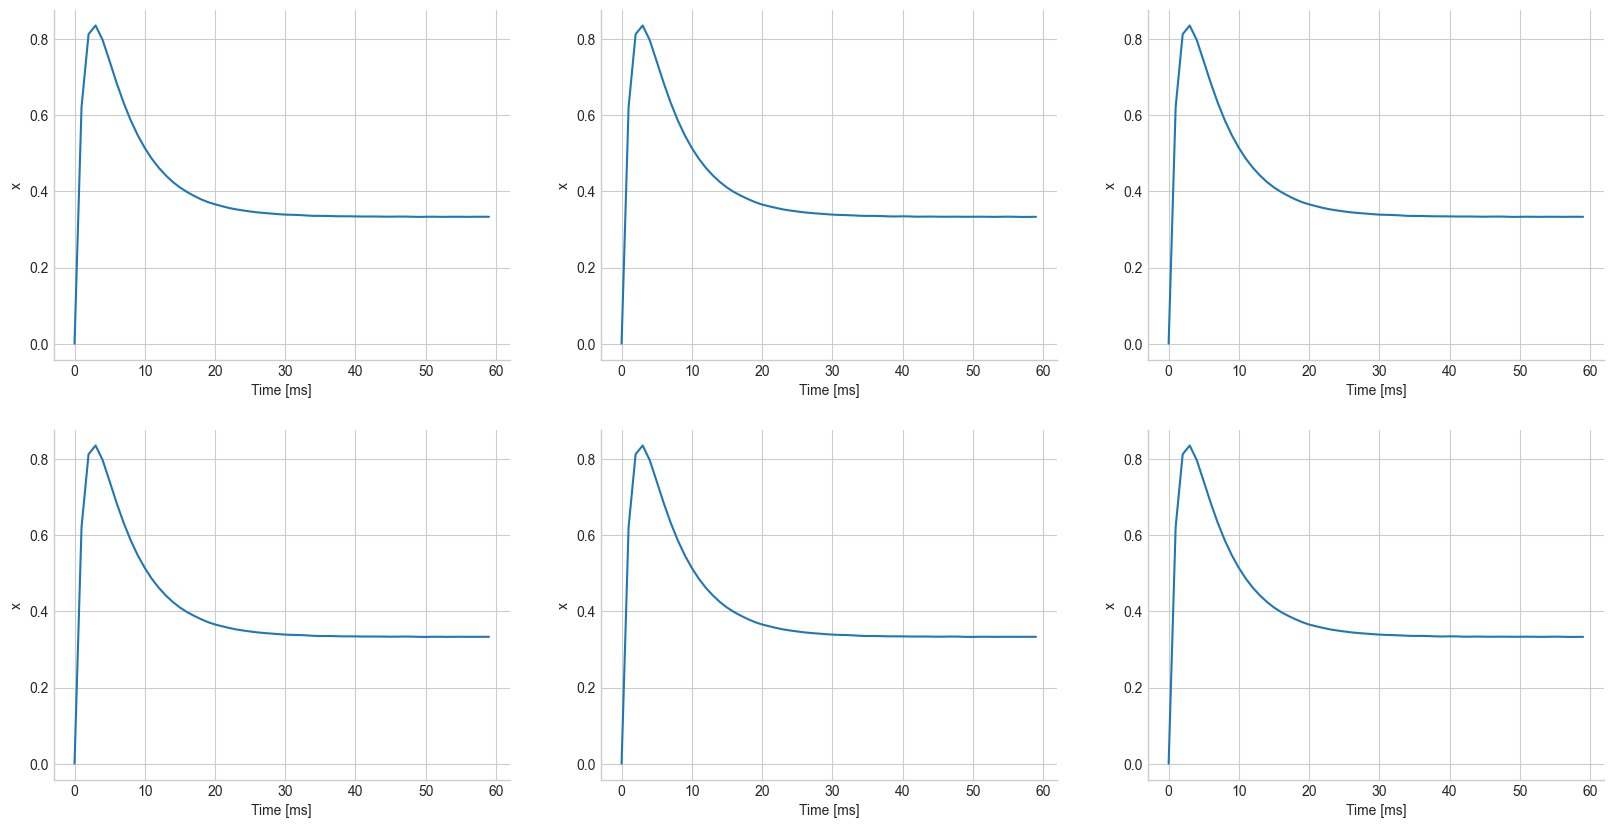

In [4]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
t_plotting = np.arange(0, tf, 1)

for i in range(6):
    ax[i//3, i%3].plot(t_plotting, x[i])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

In [5]:
data = np.empty([num_curves*2, tf])

for i in range(num_curves):
    data[i] = x[i]

# IFFL

In [6]:
# K3 = 0

# B = 1.05
# C = 0.15
# Q = 0.05

# Initial curve parameters
K4 = (-B + np.sqrt(B**2 - 4*C)) / (-2)
K1 = B - K4
K3 = 0

B = K1 + K4 # -> K1 = B-K4 -> K1 = 0.8794361719689456
C = K1*K4 # -> K4*(B-K4) = C -> 0 = -K4^2 + B*K4 - C -> K4 = 0.1705638280310544
Q = 0.05

# K1 and K4 have to be fixed to their respective values
K2_vals = np.random.uniform(0, 3, num_curves)
xi_vals = (K4-Q)/K2_vals

print(f"K1: {K1}, K4: {K4}, B: {B}, C: {C}, Q: {Q}.")

K1: 0.8794361719689456, K4: 0.1705638280310544, B: 1.05, C: 0.15000000000000002, Q: 0.05.


In [7]:
# Solve the system for each pair of K2 and xi
x = np.empty((num_curves, np.shape(indices)[0]))

for i in tqdm(range(num_curves)):
    sol = simulator(K1, K2_vals[i], K3, K4, Ac, xi_vals[i])
    x[i] = sol.y[0][indices]

100%|██████████| 25000/25000 [14:42<00:00, 28.32it/s]


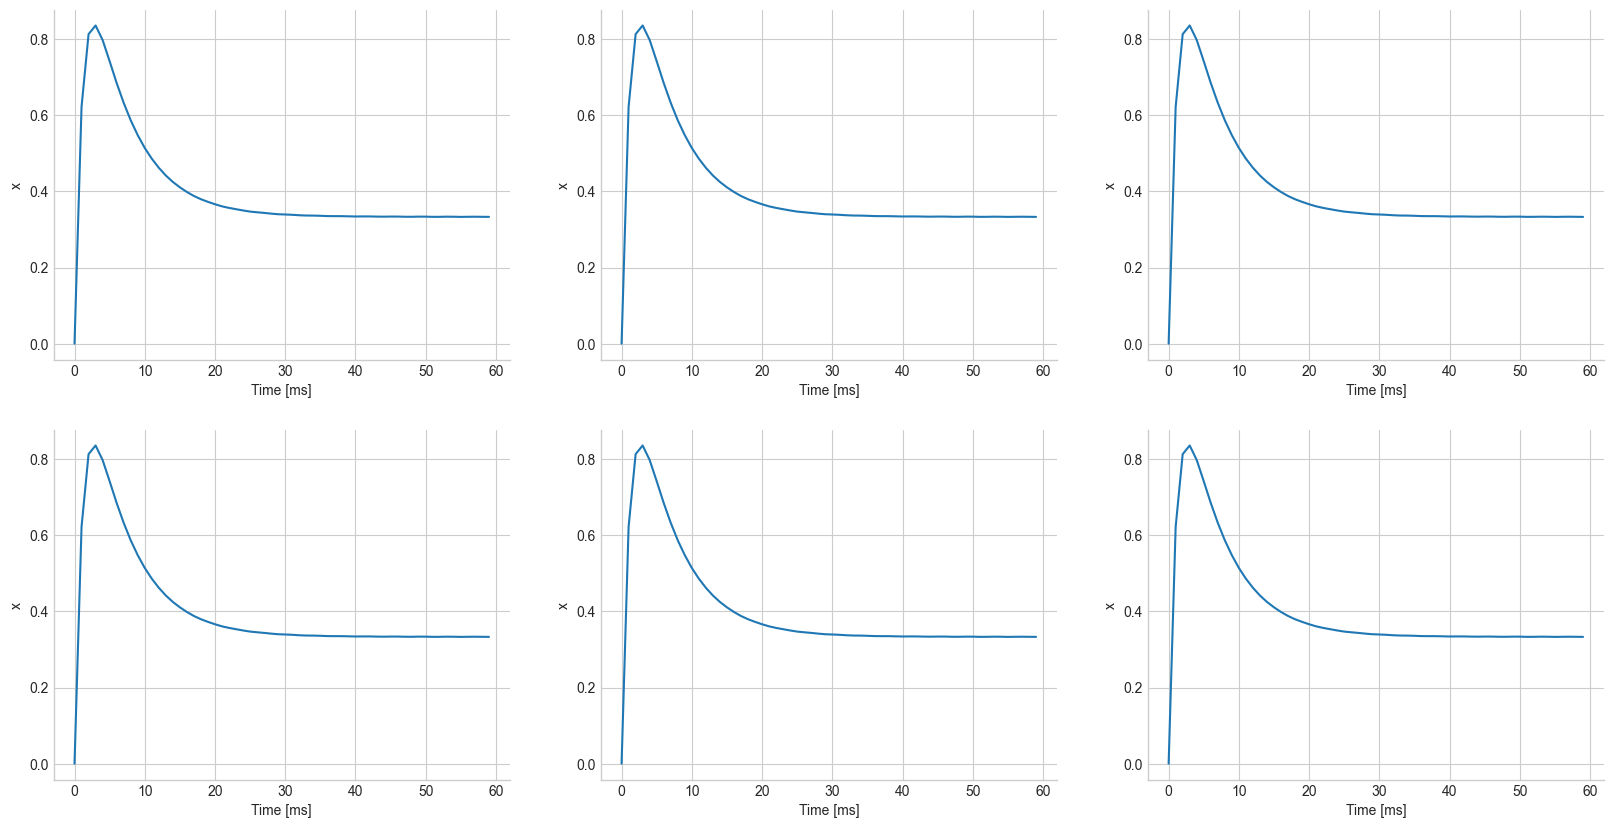

In [8]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t_plotting, x[i])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

In [9]:
for i in range(num_curves):
    data[num_curves+i] = x[i]

In [10]:
# Create the labels array
# 1 NFBL, 0 IFFL
labels = np.empty(total_curves)
labels[:num_curves] = 1
labels[num_curves:] = 0

In [11]:
# Save the data
np.savetxt("data_00001.csv", data, delimiter=",")
np.savetxt("labels.csv", labels, delimiter=",")